<a href="https://colab.research.google.com/github/willianncardoso/IBOVESPA/blob/LightGBM/PosFIAP_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Random Forest Classifier

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

In [123]:
# 1. Obtenção dos Dados
# Usando 'period' para pegar os dados dos últimos 2 anos
dados = pd.read_csv('https://raw.githubusercontent.com/willianncardoso/IBOVESPA/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv')

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
1,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"
2,02.07.2025,139.051,139.586,140.049,138.384,"8,81B","-0,36%"
3,01.07.2025,139.549,138.855,139.695,138.855,"6,35B","0,50%"
4,30.06.2025,138.855,136.865,139.103,136.430,"7,68B","1,45%"


In [124]:
def converter_volume_simples(valor):
    # Deixa tudo maiúsculo, troca vírgula por ponto e remove espaços
    valor_str = str(valor).upper().replace(',', '.').strip()

    if 'B' in valor_str:
        return int(float(valor_str.replace('B', '')) * 1_000_000_000)
    elif 'M' in valor_str:
        return int(float(valor_str.replace('M', '')) * 1_000_000)
    else:
        # Se não tiver letra, apenas converte para número
        return int(float(valor_str))

dados['Vol.'] = dados['Vol.'].apply(converter_volume_simples)

# Convertendo a data formato
dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y')

# Inverter Data Ascending
dados.sort_values(by='Data', ascending=True, inplace=True)

# Data como índice
dados.set_index('Data', inplace=True)


In [125]:
dados['Var%'] = pd.to_numeric(dados['Var%'].str.replace('%', '').str.replace(',', '.')) / 100

dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2023-06-30 to 2025-07-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    502 non-null    float64
 1   Abertura  502 non-null    float64
 2   Máxima    502 non-null    float64
 3   Mínima    502 non-null    float64
 4   Vol.      502 non-null    int64  
 5   Var%      502 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [126]:
# 2. Engenharia de Atributos para Classificação

# Criando a variável-alvo (Target)
# 1 se o preço de fechamento de amanhã for MAIOR que o de hoje, 0 caso contrário
dados['Target'] = (dados['Último'].shift(-1) > dados['Último']).astype(int)

# Remover a última linha que terá um 'Target' NaN
dados.dropna(inplace=True)

In [129]:
# criação de uma feature de variação segura, que olha para o passado.
dados['Variacao_Dia_Anterior'] = dados['Último'].pct_change()

# Lembre-se que isso vai criar um NaN na primeira linha, então
# é importante rodar o dropna() depois de criar todas as features
dados.dropna(inplace=True)

dados

,Último,Abertura,Máxima,Mínima,Vol.,Target,Variacao_Dia_Anterior
Data,,,,,,,
2023-07-03,119.673,118.092,119.877,118.092,8910000,0,0.013431
2023-07-04,119.076,119.673,119.678,118.830,6560000,1,-0.004989
2023-07-05,119.549,119.072,120.200,118.688,10960000,0,0.003972
2023-07-06,117.426,119.548,119.548,117.096,11030000,1,-0.017758
2023-07-07,118.898,117.427,119.549,117.427,10520000,0,0.012536
...,...,...,...,...,...,...,...
2025-06-30,138.855,136.865,139.103,136.430,7680000000,1,0.014532
2025-07-01,139.549,138.855,139.695,138.855,6350000000,0,0.004998
2025-07-02,139.051,139.586,140.049,138.384,8810000000,1,-0.003569


In [130]:
# Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 400 amostras
Tamanho do conjunto de Teste: 101 amostras


In [131]:
print("--- Verificando as colunas em X antes do treino ---")
print(X_treino.columns.tolist())

--- Verificando as colunas em X antes do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Variacao_Dia_Anterior']


In [132]:
# Inicializar o modelo LightGBM
# Usamos random_state para garantir que os resultados sejam reproduzíveis
lgbm_model = LGBMClassifier(random_state=42)

In [133]:
# Treinar o modelo com os mesmos dados de treino
print("Treinando o modelo...")
lgbm_model.fit(X_treino, y_treino)

Treinando o modelo...
[LightGBM] [Info] Number of positive: 197, number of negative: 203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492500 -> initscore=-0.030002
[LightGBM] [Info] Start training from score -0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

LGBMClassifier(random_state=42)

In [134]:
# Fazer as previsões no conjunto de teste
print("Fazendo previsões...")
previsoes_lgbm = lgbm_model.predict(X_teste)

Fazendo previsões...


In [138]:
#  Avaliar a Acurácia
acuracia_lgbm = accuracy_score(y_teste, previsoes_lgbm)
acuracia_anterior = 0.60 # Sua acurácia anterior com o RandomForest

print("\n--- COMPARAÇÃO DE RESULTADOS ---")
print(f"Acurácia do Modelo Anterior (RandomForest): {acuracia_anterior:.2%}")
print(f"Acurácia do Novo Modelo (LightGBM): {acuracia_lgbm:.2%}")


--- COMPARAÇÃO DE RESULTADOS ---
Acurácia do Modelo Anterior (RandomForest): 60.00%
Acurácia do Novo Modelo (LightGBM): 48.51%



--- Análise Detalhada do LightGBM ---

Relatório de Classificação:
              precision    recall  f1-score   support

Caiu/Manteve       0.46      0.93      0.62        45
       Subiu       0.70      0.12      0.21        56

    accuracy                           0.49       101
   macro avg       0.58      0.53      0.41       101
weighted avg       0.59      0.49      0.39       101


Matriz de Confusão:


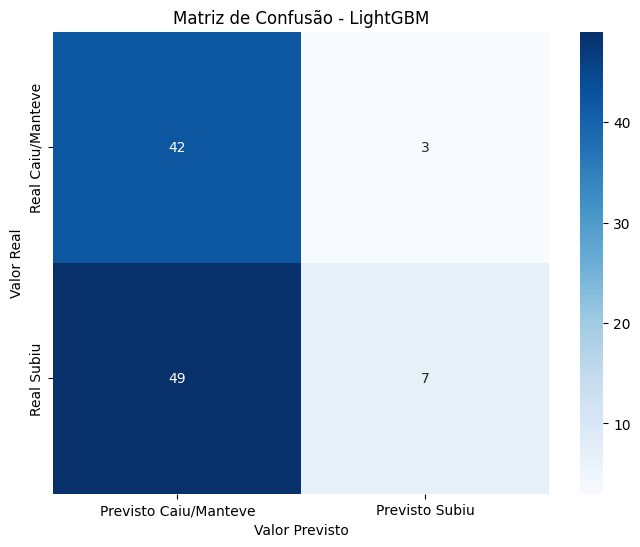

In [139]:
# Análise Detalhada do LightGBM
print("\n--- Análise Detalhada do LightGBM ---")
print("\nRelatório de Classificação:")
print(classification_report(y_teste, previsoes_lgbm, target_names=['Caiu/Manteve', 'Subiu']))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão - LightGBM')
plt.show()